# Image Classification using CNN:

In [73]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import pycuda.driver as cuda

# Loading the Data:

In [4]:
trainset = torchvision.datasets.CIFAR10('./data',train = True,transform= transforms.ToTensor(),download=True)

Extracting ./data\cifar-10-python.tar.gz to ./data


In [5]:
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

In [6]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size = 4,shuffle = True)

In [7]:
dataiter = iter(trainloader)
images,labels = dataiter.next()
print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([4, 3, 32, 32])
torch.Size([3, 32, 32])
8


# Visualizing Images:

In [14]:
# convert torch tensor to numpy array
npimg = images[0].numpy()
print(npimg.shape)

(3, 32, 32)


In [16]:
npimg = np.transpose(npimg,(1,2,0))
print(npimg.shape)

(32, 32, 3)


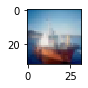

In [17]:
plt.figure(figsize = (1,1))
plt.imshow(npimg)
plt.show()

In [18]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

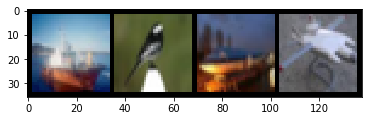

ship bird plane plane


In [25]:
imshow(torchvision.utils.make_grid(images))
print(' '.join(classes[labels[j]] for j in range(4)))

# LeNet:

In [48]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(3,6,5),
        nn.Tanh(),
        nn.AvgPool2d(2,stride = 2),
        nn.Conv2d(6,16,5),
        nn.Tanh(),
        nn.AvgPool2d(2,stride = 2),
        )
        self.fc_model = nn.Sequential(
        nn.Linear(400,120),
        nn.Tanh(),
        nn.Linear(120,84),
        nn.Tanh(),
        nn.Linear(84,10)
        )
    
    def forward(self,x):
#         print(x.shape)
        x = self.cnn_model(x)
#         print(x.shape)
        x = x.view(x.size(0),-1)
#         print(x.shape)
        x = self.fc_model(x)
#         print(x.shape)
        return x

In [49]:
net = LeNet()
out = net(images)

In [50]:
print(out)

tensor([[-0.0879, -0.0652, -0.0167,  0.0997, -0.1256,  0.0166,  0.0844,  0.0309,
         -0.0683, -0.0523],
        [-0.0922, -0.0536, -0.0067,  0.0701, -0.1110,  0.0279,  0.0471,  0.0172,
         -0.0911, -0.0228],
        [-0.0805, -0.0658, -0.0026,  0.0952, -0.1169, -0.0040,  0.0696,  0.0278,
         -0.0665, -0.0312],
        [-0.0916, -0.0557, -0.0035,  0.0937, -0.1184,  0.0130,  0.0754,  0.0196,
         -0.0626, -0.0563]], grad_fn=<AddmmBackward>)


In [51]:
max_values,pred_class = torch.max(out.data,1)
print(pred_class)

tensor([3, 3, 3, 3])


# Train LeNet:

In [52]:
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root = './data',train = True,download = True,transform = transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset,batch_size = batch_size, shuffle = True)
testset = torchvision.datasets.CIFAR10(root = './data',train = False,download = True,transform = transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size , shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


In [57]:
def evaluation(dataloader):
    total, correct = 0,0
    for data in dataloader:
        inputs,labels = data
        outputs = net(inputs)
        _,pred = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [58]:
net = LeNet()

In [59]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

Epoch: 0/16, Test acc: 39.09, Train acc: 38.90
Epoch: 1/16, Test acc: 43.02, Train acc: 42.88
Epoch: 2/16, Test acc: 46.14, Train acc: 46.49
Epoch: 3/16, Test acc: 48.40, Train acc: 50.10
Epoch: 4/16, Test acc: 50.34, Train acc: 51.55
Epoch: 5/16, Test acc: 51.48, Train acc: 54.07
Epoch: 6/16, Test acc: 52.87, Train acc: 55.93
Epoch: 7/16, Test acc: 53.24, Train acc: 57.32
Epoch: 8/16, Test acc: 53.64, Train acc: 58.25
Epoch: 9/16, Test acc: 54.15, Train acc: 59.45
Epoch: 10/16, Test acc: 54.95, Train acc: 60.50
Epoch: 11/16, Test acc: 54.31, Train acc: 60.69
Epoch: 12/16, Test acc: 55.21, Train acc: 62.36
Epoch: 13/16, Test acc: 54.98, Train acc: 63.32
Epoch: 14/16, Test acc: 55.10, Train acc: 63.88
Epoch: 15/16, Test acc: 55.39, Train acc: 64.99


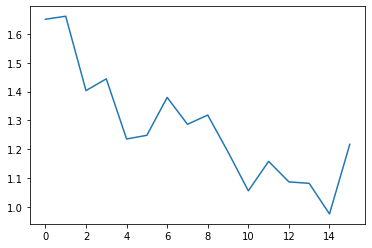

Wall time: 16min 42s


In [60]:
%%time 
loss_arr = []
loss_epoch_arr = []
max_epoch = 16

for epoch in range(max_epoch):
    
    for i,data in enumerate(trainloader,0):
        
        inputs, labels = data
        opt.zero_grad()
        
        outputs= net(inputs)
        loss = loss_fn(outputs,labels)
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
        
    loss_epoch_arr.append(loss.item())
    
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f'% (epoch,max_epoch,evaluation(testloader),evaluation(trainloader)))

plt.plot(loss_epoch_arr)
plt.show()

# Move to GPU:

In [61]:
device = torch.device("cuda:0")
print(device)

cuda:0


In [75]:
torch.cuda.current_device()
cuda.Device(0).name()

'GeForce MX150'

In [76]:
num = cuda.Device.count()
print("%d device(s) found:"%num)
for i in range(num):
    print(cuda.Device(i).name(), "(Id: %d)"%i)

1 device(s) found:
GeForce MX150 (Id: 0)


In [79]:
print(cuda.mem_get_info())

(3139334553, 4294967296)


In [62]:
def evaluation(dataloader):
    total, correct=0,0
    for data in dataloader:
        inputs,labels = data
        inputs,labels = inputs.to(device),labels.to(device)
        outputs = net(inputs)
        _,pred = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct/total

In [63]:
net = LeNet().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

Epoch: 0/16, Test acc: 38.11, Train acc: 37.84
Epoch: 1/16, Test acc: 43.69, Train acc: 43.88
Epoch: 2/16, Test acc: 47.37, Train acc: 47.61
Epoch: 3/16, Test acc: 48.65, Train acc: 49.85
Epoch: 4/16, Test acc: 49.72, Train acc: 52.02
Epoch: 5/16, Test acc: 51.24, Train acc: 54.25
Epoch: 6/16, Test acc: 52.07, Train acc: 55.97
Epoch: 7/16, Test acc: 52.93, Train acc: 57.35
Epoch: 8/16, Test acc: 52.95, Train acc: 58.36
Epoch: 9/16, Test acc: 54.03, Train acc: 59.84
Epoch: 10/16, Test acc: 54.53, Train acc: 61.13
Epoch: 11/16, Test acc: 54.02, Train acc: 61.19
Epoch: 12/16, Test acc: 54.27, Train acc: 62.45
Epoch: 13/16, Test acc: 55.60, Train acc: 64.07
Epoch: 14/16, Test acc: 54.66, Train acc: 63.94
Epoch: 15/16, Test acc: 55.24, Train acc: 64.45


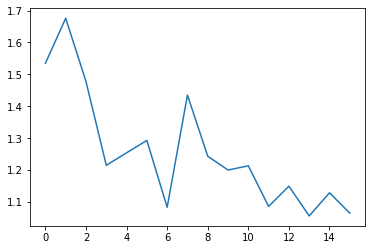

Wall time: 6min 26s


In [65]:
%%time
max_epoch = 16
loss_arr = []
loss_epoch_arr =[]

for epoch in range(max_epoch):
    
    for i,data in enumerate(trainloader,0):
        
        inputs,labels = data
        inputs,labels = inputs.to(device),labels.to(device)
        opt.zero_grad()
        
        outputs = net(inputs)
        loss = loss_fn(outputs,labels)
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
    loss_epoch_arr.append(loss.item())
    
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f'% (epoch,max_epoch,evaluation(testloader),evaluation(trainloader)))

plt.plot(loss_epoch_arr)
plt.show()

(3, 32, 32)
(32, 32, 3)


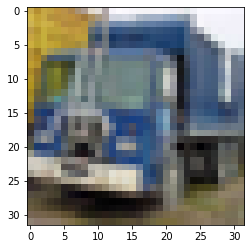

truck


In [100]:
itr = iter(testloader)
imgs,labels  = itr.next()
npimg = imgs[14].numpy()
print(npimg.shape)
npimg = np.transpose(npimg,(1,2,0))
print(npimg.shape)
plt.imshow(npimg)
plt.show()
print(classes[labels[14].item()])